In [21]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pylab as plt
import json
from pandas import json_normalize

In [6]:
api_key = 'RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc'

## Overview and caveats

This python notebook contains code and plots for an intitial analysis of the OpenFDA drugs adverse events data, queried through the API. While the entire data-set contains several million records, the results here are mostly based on querying for smaller subsets of the data as the API endpoints are limited in the amount of data they return. This is true for both count based summary queries (limited to 1000 highest counts), as well as queries for actual records (limited to 100 records). As such, not all the results presented here will generalize to the entire dataset. A fuller, more robust analysis would ideally first download the entire data-set as JSON file locally and work off those.

## Exploratory data analysis

This section contains code for exploratory analysis and plots. The aim is to get an overall understanding of the scale and various trends in the data.  

### Countries with highest number of adverse event reports

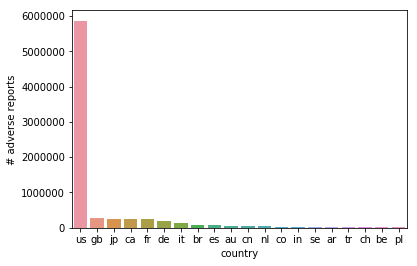

In [11]:
query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&count=occurcountry&limit=20' 
response = requests.get(query)
response_df = json_normalize(response.json()['results'])
ax = sns.barplot(x=response_df['term'], y=response_df['count'])
ax.set(xlabel='country', ylabel='# adverse reports')
plt.show()

By far the largest number of adverse events are reported in the Unitet States, followed by Great Britain and Japan.

### Distribution of adverse event reports with patient sex

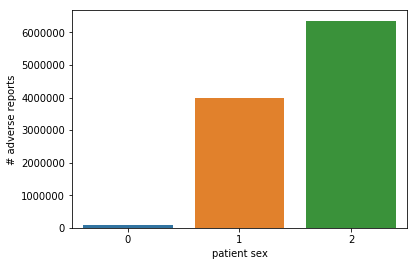

In [14]:
query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&count=patient.patientsex' 
response = requests.get(query)
response_df = json_normalize(response.json()['results'])
ax = sns.barplot(x=response_df['term'], y=response_df['count'])
ax.set(xlabel='patient sex', ylabel='# adverse reports')
plt.show()

There is a substantial gender imbalance in the reported, with females (code = 2) accounting for nearly twice as many reports as males. 

### Distribution of adverse event reports with patient age

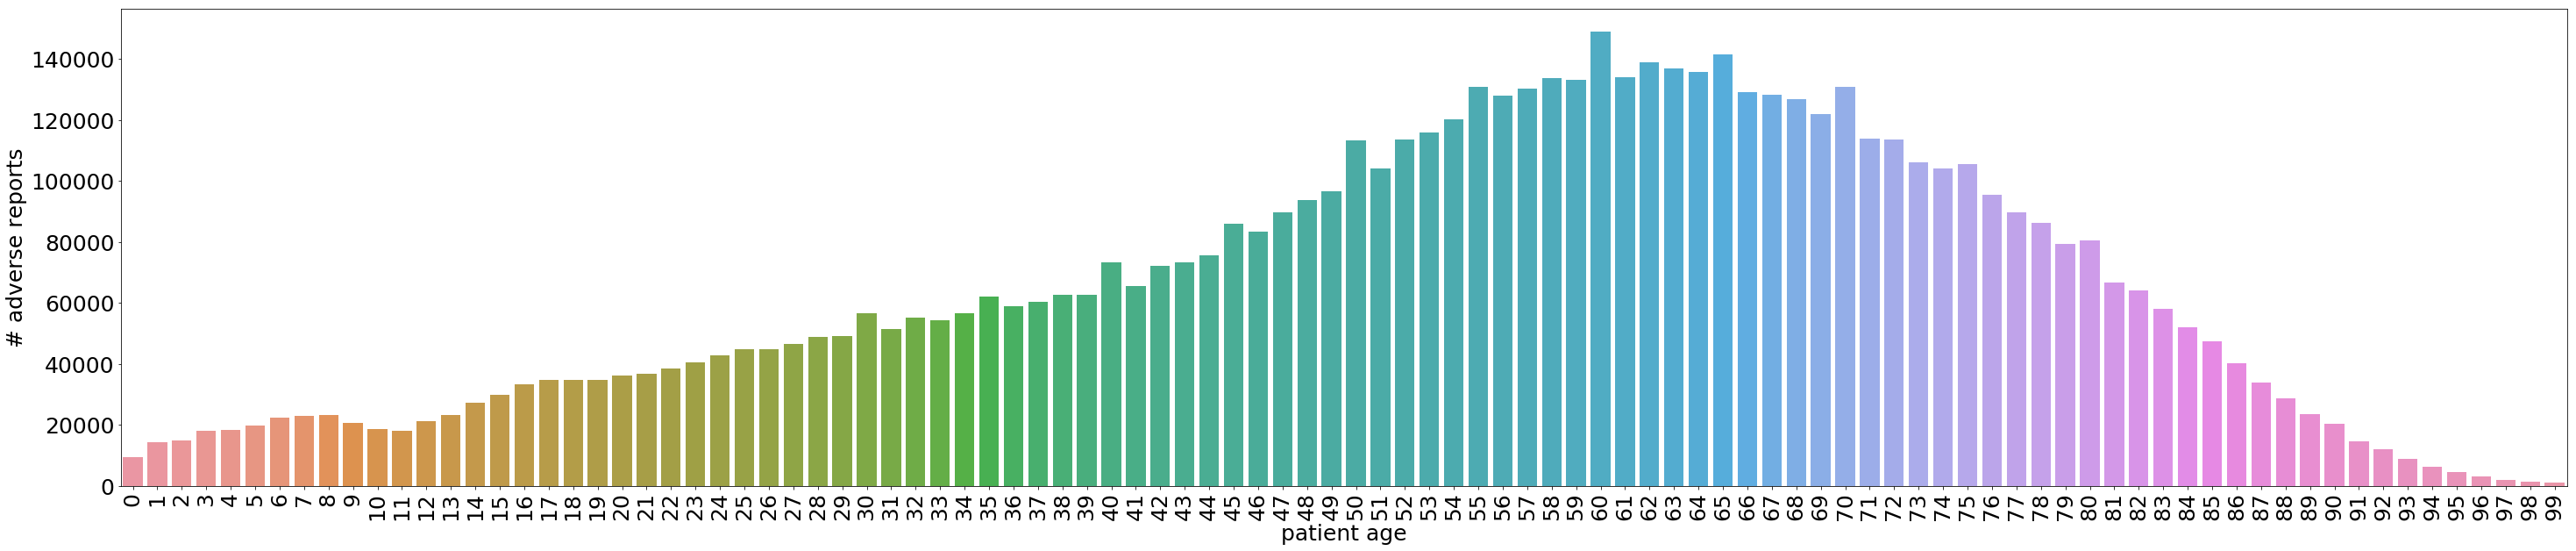

In [21]:
query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&count=patient.patientonsetage' 
response = requests.get(query)
response_df = json_normalize(response.json()['results'])

plt.figure(figsize=(50, 10))
plt.rcParams.update({'font.size': 25})
plt.xticks(rotation=90)
ax = sns.barplot(x=response_df['term'], y=response_df['count'])
ax.set(xlabel='patient age', ylabel='# adverse reports')
plt.show()

The range of patient ages represented in the adverse reports is fairly broad, with an expected peak around 60. Patients aged 50+ are more likely to be on medications in general, with the decline at higher ages probably a reflection of lower numbers of patients alive.  

### Top three drug class with most reports by year (2010 to 2020)

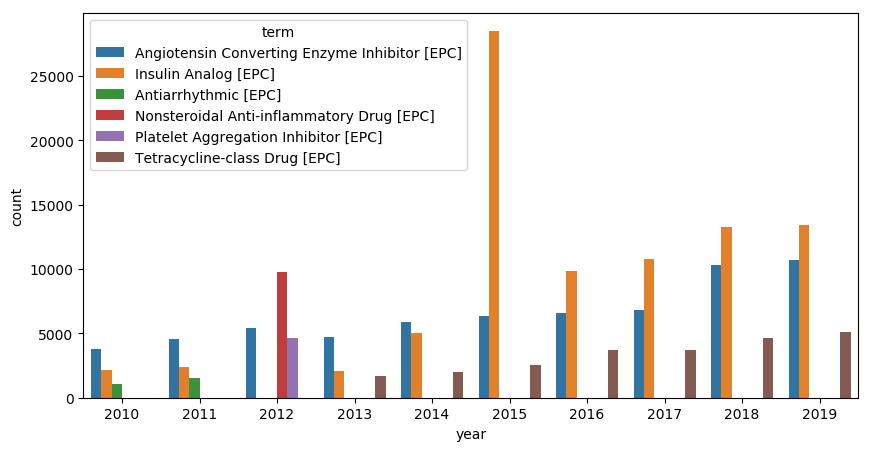

In [49]:
years = range(2010, 2020)
year_df_list = []
for year in years:
    query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&search=receivedate:[{}0101+TO+{}1230]&count=patient.drug.openfda.pharm_class_epc.exact&limit=3'.format(year, year)
    response = requests.get(query)
    response_df = json_normalize(response.json()['results'])
    response_df['year'] = year
    year_df_list.append(response_df)
year_df = pd.concat(year_df_list)


plt.style.use('default')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='term', data=year_df)
plt.show()
    
    

The aim here is to see if there is a change with time in the broad pattern of drug classes vs. frequency of adverse events. The plot indicates that there is an overall increasing trend in reported adverse events over time, though the relative frequency of the top three classes is fairly stable from 2015 onwards. There is an interesting spike in reported adverse effects for the Nonsteroidal anti-inflammatory drug class in 2012.  

## Are different adverse events reported in different countries?

One possible high-level approach to answer this question would be to quantify the similairty between countries in terms of their reported adverse events. I use the Jaccard similarity index below to define similarity between pairs of countries in terms of the overlap between their reported adverse events. Due to time constraints, I have only used the top 50 adverse events for each country here. 

### Get list of countries

In [22]:
query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&count=occurcountry&limit=1000' 
response = requests.get(query)
response_df = json_normalize(response.json()['results'])
countries = response_df['term'].values

### Create matrix of Jaccard similairty between countries 

In [ ]:
response_dict = {}
for country in countries:
    query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&search=occurcountry:{}&count=patient.reaction.reactionmeddrapt.exact&limit=50'.format(country) 
    response = requests.get(query)
    response_dict[country] = json_normalize(response.json()['results'])['term'].values
   
    

In [41]:
def jaccard_similarity(A, B):
    return len(set(A).intersection(set(B)))/len(set(A).union(set(B)))

from collections import defaultdict
country_similarity_dict = defaultdict(dict)
for country_A in countries:
    for country_B in countries:
        country_similarity_dict[country_A][country_B] = jaccard_similarity(response_dict[country_A], response_dict[country_B])
        

In [42]:
country_similarity_df = pd.DataFrame.from_dict(country_similarity_dict)
country_similarity_df = country_similarity_df[country_similarity_df.index.values]

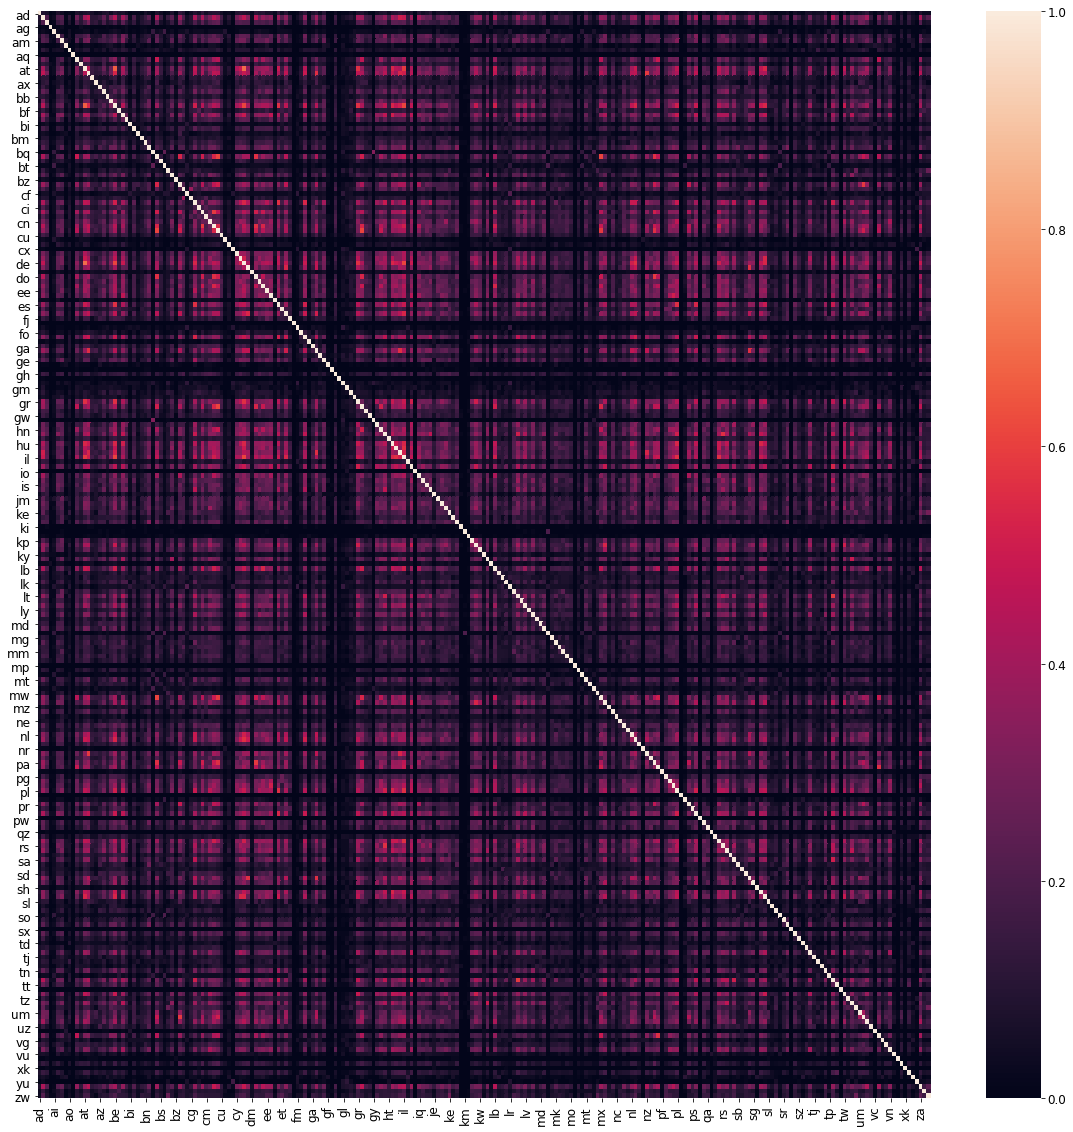

In [43]:
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 12})
sns.heatmap(country_similarity_df)
plt.show()

The Jaccard similarity matrix plotted above indicates that while there are some countries which have similarities in their most common adverse events, there are quite a few countries (black lines) which do not share their most common adverse events.

Another way to explore the difference in occurence of adverse events across countries would be to focus on events that are only reported for few countries. Below, I identify the 500 most common adverse events overall, and then identify the subset of these which are reported within the top 500 events in less than 5 countries.

### Get list of 500 most common adverse reactions

In [23]:
query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&count=patient.reaction.reactionmeddrapt.exact&limit=500'
response = requests.get(query)
response_df = json_normalize(response.json()['results'])
country_reaction_df = response_df.set_index('term').drop('count', axis=1)

### Create dataframe with reactions as row index and countries as columns

In [24]:
for country in countries:
    query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&search=occurcountry:{}&count=patient.reaction.reactionmeddrapt.exact&limit=500'.format(country) 
    response = requests.get(query)
    response_df = json_normalize(response.json()['results'])
    response_df.rename(columns={'count':country }, inplace=True)
    response_df = response_df.set_index('term')
    country_reaction_df = pd.merge(country_reaction_df, response_df, how='left', left_index=True, right_index=True)

In [33]:
exclusive_country_events = country_reaction_df.loc[country_reaction_df.notnull().sum(axis=1) < 5]
exclusive_country_events = exclusive_country_events.dropna(how='all', axis=1)
exclusive_country_events = exclusive_country_events.dropna(how='all')

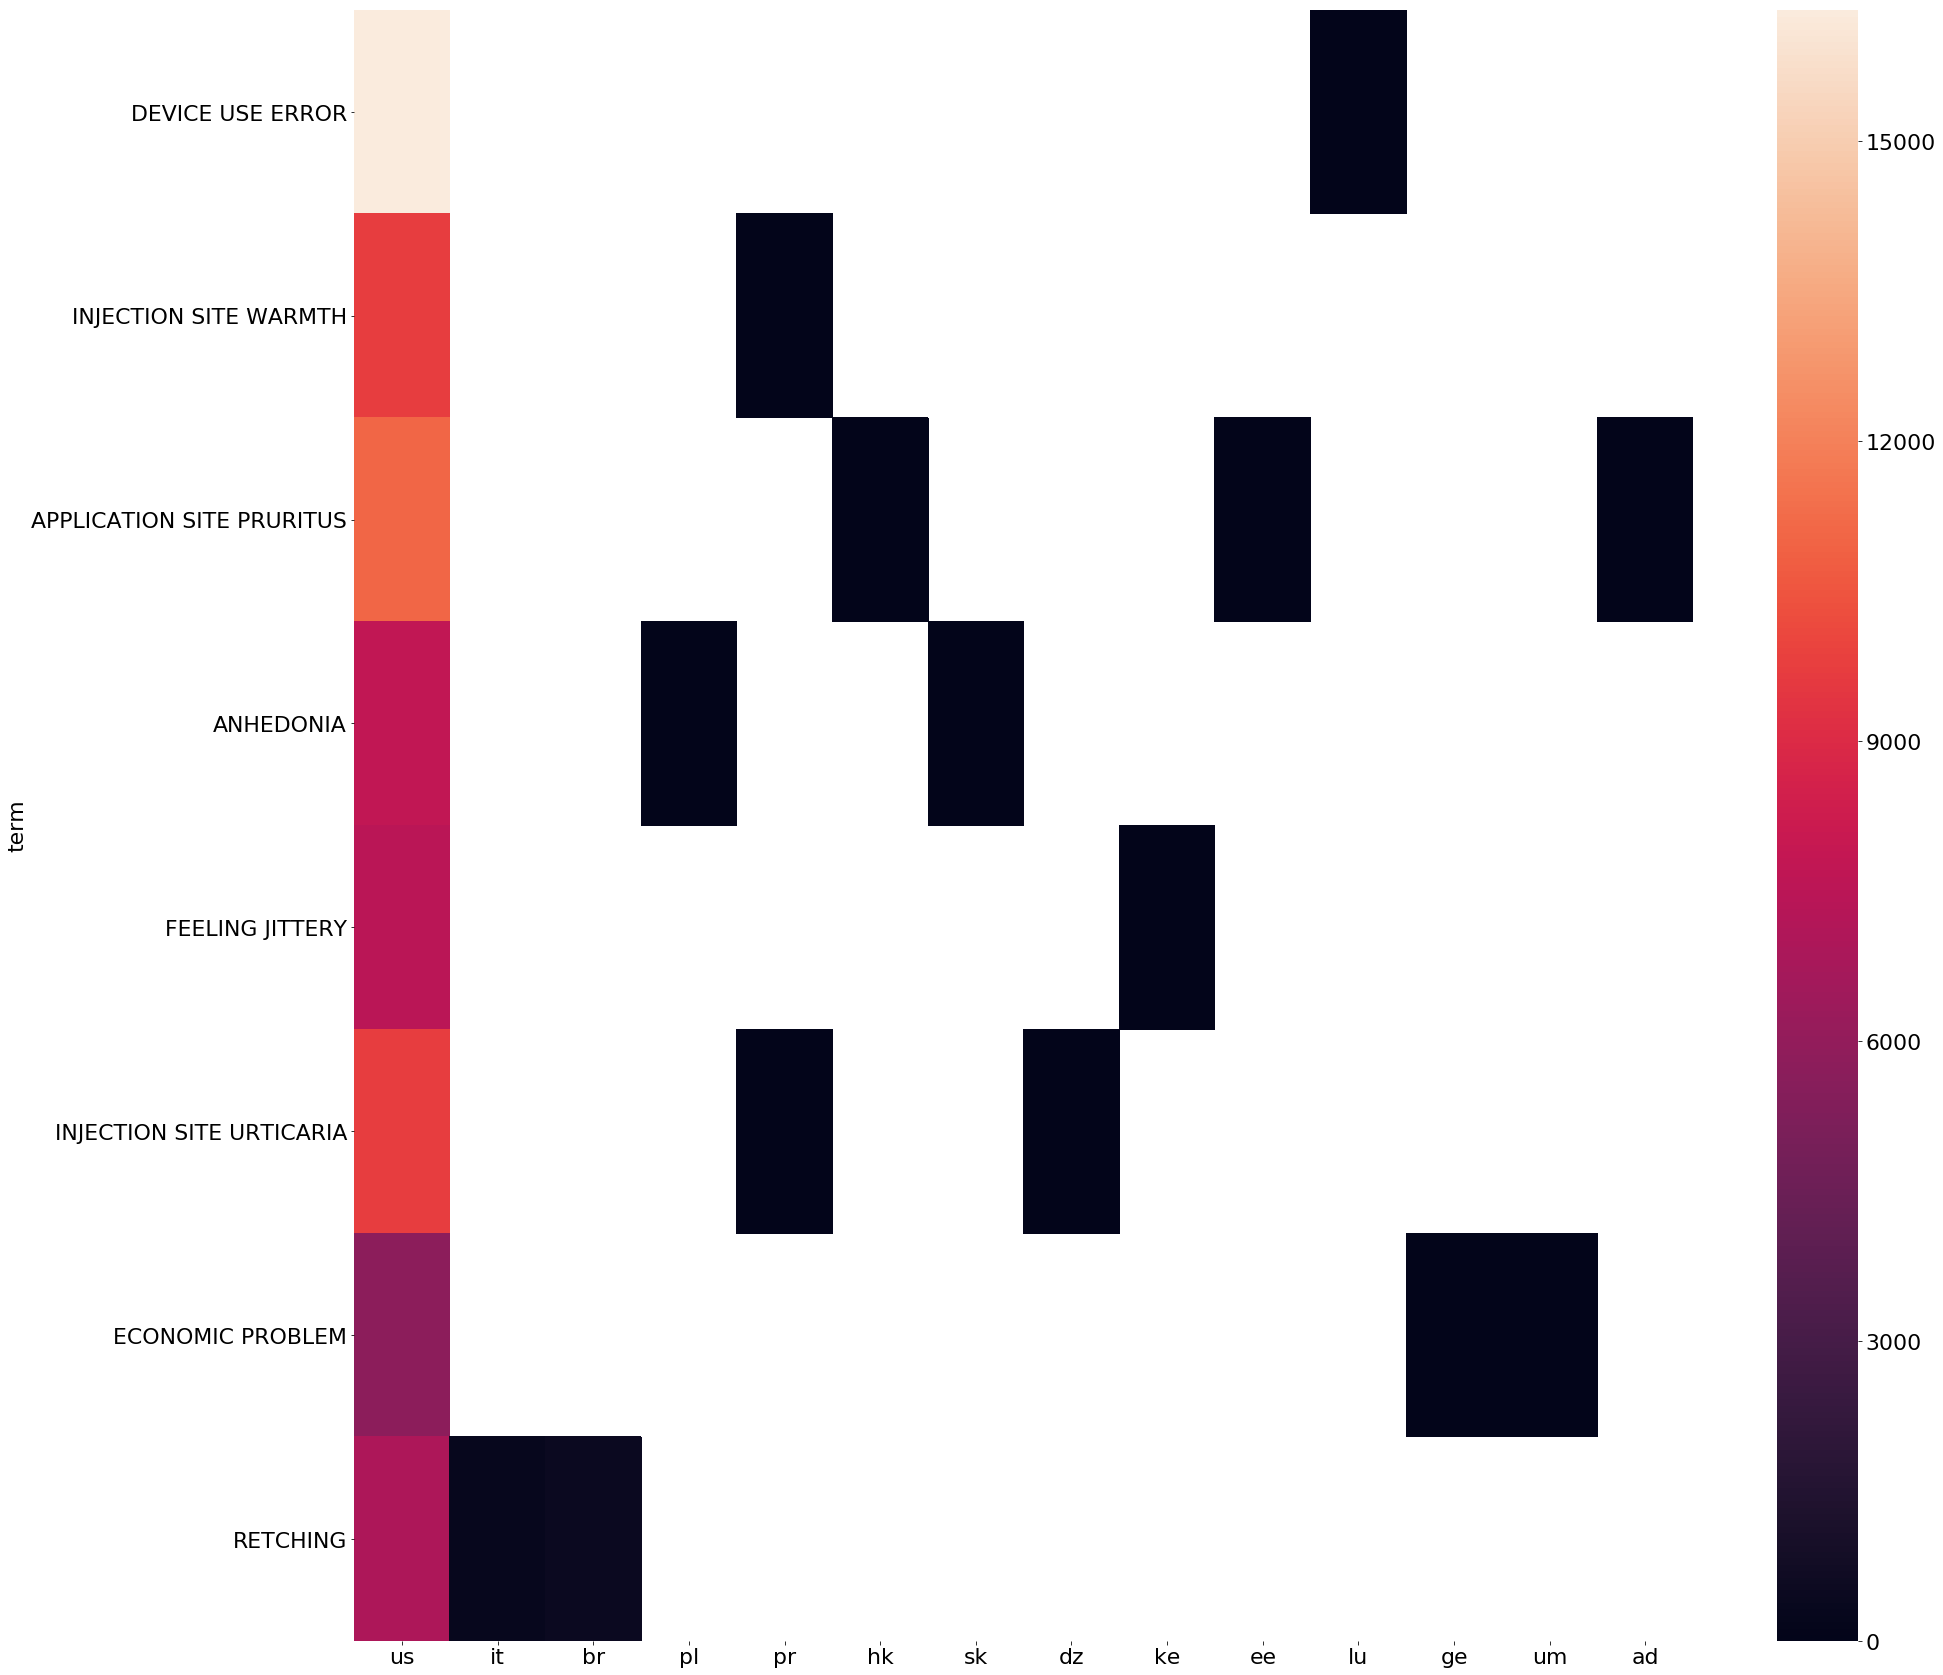

In [34]:
plt.figure(figsize=(30, 30))
plt.rcParams.update({'font.size': 22})
sns.heatmap(exclusive_country_events, xticklabels=True, yticklabels=True)
plt.show()

As seen in the plot above, several adverse events are only present in the United States and a few other countries. It must be noted that this is based on only the top 500 events for each country, and a complete analysis based on systematic analysis of all reports may well identify other patterns.  

## What drugs tend to be taken together?

The approach I will take here is to identify drugs that occur most together in reports, using frequent itemset  identificaton. Due to time constraints, I will only look for upto triplets of co-occurring drugs. The results here will be based on a small sample of reports from the years 2010-2019 and may not be generalize to the entire set of reports in the database.

### Create a sample of co-occurring drugs 

In [14]:
years = range(2010, 2020)
drug_occurence_list = []
for year in years:
    num_records = 0
    skip = 0
    while (num_records < 1000):
        query = 'https://api.fda.gov/drug/event.json?api_key=RyuEQDfSTS3W9kbvli74kHiQciQry3sq74iMJoLc&search=receivedate:[{}0101+TO+{}1230]&skip={}&limit=100'.format(year, year, skip)
        response = requests.get(query)
        for record in response.json()['results']:
            drugs = [x['medicinalproduct'] for x in record['patient']['drug']]
            drugs = list(set(drugs))
            if len(drugs) > 1:
                drug_occurence_list.append(drugs)
                num_records += 1
        skip += 100    

### Find most frequent itemsets (upto length 3) of drugs in the sample

In [16]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

te = TransactionEncoder()
te_ary = te.fit(drug_occurence_list).transform(drug_occurence_list)
df = pd.DataFrame(te_ary, columns=te.columns_)

freq_itemsets = apriori(df, min_support=0.01, max_len=3, use_colnames=True)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
freq_itemsets[freq_itemsets['length'] > 1]

,support,itemsets,length
81,0.019086,"(PREMARIN, MEDROXYPROGESTERONE ACETATE)",2
82,0.016933,"(MEDROXYPROGESTERONE ACETATE, PREMPRO)",2
83,0.012332,"(MEDROXYPROGESTERONE ACETATE, PROVERA)",2
84,0.011843,"(PREDNISONE., MYCOPHENOLATE MOFETIL.)",2
85,0.013409,"(TACROLIMUS., MYCOPHENOLATE MOFETIL.)",2
86,0.037780,"(PREMARIN, PREMPRO)",2
87,0.038857,"(PREMARIN, PROVERA)",2
88,0.031222,"(PROVERA, PREMPRO)",2
89,0.015171,"(PREMARIN, MEDROXYPROGESTERONE ACETATE, PREMPRO)",3
90,0.012039,"(PREMARIN, MEDROXYPROGESTERONE ACETATE, PROVERA)",3


As seen above, in the sample of reports analyzed here, the most common drug pair reported together is PREMARIN and MEDROXYPROGESTERONE ACETATE. 